In [ ]:
#CNN

tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# The image data x will be of shape
#[None, 28, 28, 1]
#meaning that we have an unknown number of images, each 28×28 pixels and
#with one color channel (since these are grayscale images).

#The weights W we use will be of shape:
#[5, 5, 1, 32]
#where the initial 5×5×1 represents the size of the small “window” in the
#image to be convolved, in our case a 5×5 region. The final 32 is the number of feature maps

#The strides argument controls the spatial movement of the filter W across the image (or feature map) x.
#The value [1, 1, 1, 1] means that the filter is applied to the input in onepixel
#intervals in each dimension, corresponding to a “full” convolution

#setting padding to 'SAME' means that the borders of x are padded
#such that the size of the result of the operation is the same as the size of x.


#Pooling
tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#Max pooling outputs the maximum of the input in each region of a predefined
#size (here 2×2). The ksize argument controls the size of the pooling (2×2),
#and the strides argument controls by how much we “slide” the pooling grids
#across x, just as in the case of the convolution layer. Setting this to a 2×2 grid
#means that the output of the pooling will be exactly one-half of the height and
#width of the original, and in total one-quarter of the size.

#Dropout
tf.nn.dropout(layer, keep_prob=keep_prob)
#keep_prob 留存率 -- 在test时为1



In [1]:
#Help Function
import tensorflow as tf
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) #这个函数产生的随机数与均值的差距不会超过两倍的标准差
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

![title](img/CNN_Model_1.png)

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
DATA_DIR = 'data'
STEPS = 5000
MINIBATCH_SIZE = 50
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
                   
x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x_image, shape=[5, 5, 1, 32])
conv1_pool = max_pool_2x2(conv1)
conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))
keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)
y_conv = full_layer(full1_drop, 10)

mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)
cross_entropy =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(STEPS):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: batch[0],
                                        y_: batch[1],
                                        keep_prob: 1.0})
            print( "step {}, training accuracy {}".format(i, train_accuracy))
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
                        keep_prob: 0.5})
    X = mnist.test.images.reshape(10, 1000, 784)
    Y = mnist.test.labels.reshape(10, 1000, 10)
    test_accuracy = np.mean([sess.run(accuracy,
            feed_dict={x:X[i], y_:Y[i],keep_prob:1.0})
                for i in range(10)])
print("test accuracy: {}".format(test_accuracy))

In [2]:

DATA_PATH = "data\cifar-10-batches-py"
import os
import pickle
import numpy as np
def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict = pickle.load(fo,encoding='bytes')
    return dict
    
def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out
class CifarLoader(object):
  
    
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None
        
    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d[b"data"] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float) / 255
        self.labels = one_hot(np.hstack([d[b"labels"] for d in data]), 10)
        return self
    def next_batch(self, batch_size):
        x, y = self.images[self._i:self._i+batch_size], self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y
    


In [3]:
class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i) for i in range(1, 6)]).load()
        self.test = CifarLoader(["test_batch"]).load()

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test images: 10000


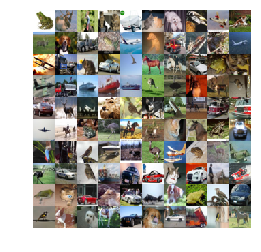

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for i in range(size)])
    plt.imshow(im)
    plt.show()
    
d = CifarDataManager()
print("Number of train images: {}".format(len(d.train.images)))
print ("Number of train labels: {}".format(len(d.train.labels)))
print ("Number of test images: {}".format(len(d.test.images)))
print ("Number of test images: {}".format(len(d.test.labels)))
images = d.train.images
display_cifar(images, 10)

In [ ]:
cifar = CifarDataManager()
STEPS = 5000
BATCH_SIZE = 100
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape = [None, 10])
keep_prob = tf.placeholder(tf.float32)

conv1 = conv_layer(x, shape = [5, 5, 3, 32])
conv_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv_pool, shape = [5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)
cross_entropy =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,labels=y_))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0}) for i in range(10)])
    print("Accuracy: {:.4}%".format(acc * 100))
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],keep_prob: 0.5})
    test(sess)


In [7]:
C1, C2, C3 = 30, 50, 80
F1 = 500
STEPS = 50000
BATCH_SIZE = 100
cifar = CifarDataManager()
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape = [None, 10])
keep_prob = tf.placeholder(tf.float32)
conv1_1 = conv_layer(x, shape=[3, 3, 3, C1])
conv1_2 = conv_layer(conv1_1, shape=[3, 3, C1, C1])
conv1_3 = conv_layer(conv1_2, shape=[3, 3, C1, C1])
conv1_pool = max_pool_2x2(conv1_3)
conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)
conv2_1 = conv_layer(conv1_drop, shape=[3, 3, C1, C2])
conv2_2 = conv_layer(conv2_1, shape=[3, 3, C2, C2])
conv2_3 = conv_layer(conv2_2, shape=[3, 3, C2, C2])
conv2_pool = max_pool_2x2(conv2_3)
conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)
conv3_1 = conv_layer(conv2_drop, shape=[3, 3, C2, C3])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, C3, C3])
conv3_3 = conv_layer(conv3_2, shape=[3, 3, C3, C3])
conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1, 8, 8, 1], strides=[1, 8, 8,
1],padding='SAME')
conv3_flat = tf.reshape(conv3_pool, [-1, C3])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)
full1 = tf.nn.relu(full_layer(conv3_flat, F1))
full1_drop = tf.nn.dropout(full1, keep_prob=keep_prob)
y_conv = full_layer(full1_drop, 10)

cross_entropy =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,labels=y_))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0}) for i in range(10)])
    print("Accuracy: {:.4}%".format(acc * 100))
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for ep in range(10):
        for i in range(STEPS):
            batch = cifar.train.next_batch(BATCH_SIZE)
            sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],keep_prob: 0.5})
        test(sess)
    test(sess)


Accuracy: 80.06%
Accuracy: 80.77%
Accuracy: 80.57%
Accuracy: 79.86%
Accuracy: 79.04%
Accuracy: 80.56%
Accuracy: 79.78%
Accuracy: 79.96%
Accuracy: 79.77%
Accuracy: 79.15%
Accuracy: 79.15%
